In [1]:
# libraries
import os
import sys
import json
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../extra_files'))
import helper as hp
from imageio import imwrite, imread
from skimage.transform import resize

In [2]:
# File paths
data_path = '/home/aldo/Documents/data-cic/'
preprocess_path = data_path + 'preprocess_data'

## Training SSD300 trained with mobilenet backbone trained

In [3]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from light_models.keras_ssd300_shufflenetv2_ssdlayers import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files.f1_callback import F1_callback as f1_call

Using TensorFlow backend.
/home/aldo/Documents/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


### Parameters (original SSD300 architecture)

In [4]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
#scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [5]:
import tensorflow as tf

run_meta = tf.RunMetadata()
with tf.Session(graph=tf.Graph()) as sess:
    K.set_session(sess)
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                input_tensor=tf.placeholder('float32', shape=(1,300,300,3)),
                mode='inference',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops = tf.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)

    opts = tf.profiler.ProfileOptionBuilder.trainable_variables_parameter()    
    params = tf.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)
    
# Factor 1.5
print("{:,} --- {:,}".format(flops.total_float_ops/2, params.total_parameters))

671,820,902.0 --- 6,028,308


## Create new model with SSD weights

In [5]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           input_stddev_normalization[0][0] 
__________________________________________________________________________________________________
model_1 (M

## Data generator for the training

In [7]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = data_path + 'PASCAL'
#images_dir = data_path + 'COCO'

# Ground truth
#train_labels_filename = preprocess_path + '/PASCAL_train.csv'
train_labels_filename = preprocess_path + '/PASCAL_train_val.csv'
val_labels_filename   = preprocess_path + '/PASCAL_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(#images_dir=images_dir,
                      data_path + 'PASCAL',
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 1025/1025 [00:04<00:00, 248.71it/s]
Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


In [8]:
# 3: Set the batch size.
batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.
# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv13_mbox_conf').output_shape[1:3],
                   model.get_layer('conv18_mbox_conf').output_shape[1:3],
                   model.get_layer('conv19_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv20_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv21_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv22_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


## Remaining training parameters

In [9]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 60:
        return 0.001
    elif epoch < 70:
        return 0.0001
    else:
        return 0.00001

In [9]:
lr_list = [0.01, 0.001, 0.0001]

for lr in lr_list:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH LEARNING RATE:', lr)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=lr)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Downloads/shufflenetv2_ssdlayers/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'model_' + str(lr) + '.csv',
                           separator=',',
                           append=True)


    f1_callback = f1_call(0.20, 
                           0.45, 
                           200, 
                           normalize_coords, 
                           img_height, 
                           img_width, 
                           (1, 2268, 14),
                           main_path + 'f1_' + str(lr) + '.csv',
                           main_path + 'model.h5',
                           label_csv='/home/aldo/Documents/data-cic/preprocess_data/PASCAL_val.csv',
                           path_img='/home/aldo/Documents/data-cic/PASCAL',
                           verborse=True)


    callbacks = [csv_logger,
                 f1_callback]
    
    initial_epoch   = 0
    final_epoch     = 100
    steps_per_epoch = 200

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=ceil(val_dataset_size/batch_size),
                                  initial_epoch=initial_epoch)

TRAINING MODEL WITH LEARNING RATE: 0.01
Epoch 1/100
200/200 [==============================] - 129s 643ms/step - loss: 107.2487 - val_loss: 108.0100
Number of images: 1025
Presicion: 0.0235
Recall: 0.2664
F1 score: 0.0432
F1 score: 0.043205474251817144
Improve F1 score from -inf to 0.043205474251817144
Epoch 2/100
200/200 [==============================] - 113s 563ms/step - loss: 106.4225 - val_loss: 115.1133
Number of images: 1025
Presicion: 0.0462
Recall: 0.358
F1 score: 0.0819
F1 score: 0.08190824377638443
Improve F1 score from 0.043205474251817144 to 0.08190824377638443
Epoch 3/100
200/200 [==============================] - 111s 556ms/step - loss: 106.3790 - val_loss: 111.2343
Number of images: 1025
Presicion: 0.0662
Recall: 0.4056
F1 score: 0.1138
F1 score: 0.11384621733559852
Improve F1 score from 0.08190824377638443 to 0.11384621733559852
Epoch 4/100
200/200 [==============================] - 106s 528ms/step - loss: 106.4568 - val_loss: 163.7366


/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:383: RuntimeWarning: invalid value encountered in true_divide
  return intersection_areas / union_areas
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:91: RuntimeWarning: invalid value encountered in less_equal
  boxes_left = boxes_left[similarities <= iou_threshold] # ...so that we can remove the ones that overlap too much with the maximum box


Number of images: 1025
Presicion: 0.0103
Recall: 0.1673
F1 score: 0.0194
F1 score: 0.019404376638740117
Epoch 5/100
200/200 [==============================] - 106s 532ms/step - loss: 106.4105 - val_loss: 147.0150
Number of images: 1025
Presicion: 0.0238
Recall: 0.2957
F1 score: 0.0441
F1 score: 0.04405261996874527
Epoch 6/100
200/200 [==============================] - 105s 527ms/step - loss: 87.5837 - val_loss: 5762851.4229


/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:175: RuntimeWarning: overflow encountered in exp
  y_pred_decoded_raw[:,:,[-2,-1]] = np.exp(y_pred_decoded_raw[:,:,[-2,-1]] * y_pred[:,:,[-2,-1]]) # exp(ln(w(pred)/w(anchor)) / w_variance * w_variance) == w(pred) / w(anchor), exp(ln(h(pred)/h(anchor)) / h_variance * h_variance) == h(pred) / h(anchor)
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:197: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-4,-2]] *= img_width # Convert xmin, xmax back to absolute coordinates
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:198: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-3,-1]] *= img_height # Convert ymin, ymax back to absolute coordinates
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:378: RuntimeWarning: invalid value encountered in multiply
  boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin] + d) * (boxes1[:,ym

Number of images: 1025
Presicion: 0.0
Recall: 0.0
F1 score: 0.0
F1 score: 0.0
Epoch 7/100
200/200 [==============================] - 106s 528ms/step - loss: 5.6170 - val_loss: 15.1533
Number of images: 1025
Presicion: 0.0315
Recall: 0.3278
F1 score: 0.0575
F1 score: 0.057477665550728155
Epoch 8/100
200/200 [==============================] - 105s 523ms/step - loss: 5.0958 - val_loss: 5.4924
Number of images: 1025
Presicion: 0.0199
Recall: 0.2898
F1 score: 0.0373
F1 score: 0.03731651479953512
Epoch 9/100
200/200 [==============================] - 105s 525ms/step - loss: 5.4040 - val_loss: 9.7180
Number of images: 1025
Presicion: 0.0237
Recall: 0.353
F1 score: 0.0445
F1 score: 0.04448223110683729
Epoch 10/100
200/200 [==============================] - 105s 525ms/step - loss: 5.1125 - val_loss: 39.6687
Number of images: 1025
Presicion: 0.0377
Recall: 0.3394
F1 score: 0.0678
F1 score: 0.06780145163729466
Epoch 11/100
200/200 [==============================] - 104s 520ms/step - loss: 4.9637 

200/200 [==============================] - 106s 530ms/step - loss: 4.2014 - val_loss: 19.8131
Number of images: 1025
Presicion: 0.0562
Recall: 0.5216
F1 score: 0.1015
F1 score: 0.10154398677484368
Epoch 85/100
200/200 [==============================] - 105s 527ms/step - loss: 4.1839 - val_loss: 9.2306
Number of images: 1025
Presicion: 0.0484
Recall: 0.5075
F1 score: 0.0884
F1 score: 0.08843187311539406
Epoch 86/100
200/200 [==============================] - 106s 528ms/step - loss: 4.1841 - val_loss: 4.7628
Number of images: 1025
Presicion: 0.0691
Recall: 0.5267
F1 score: 0.1222
F1 score: 0.12215986994332369
Epoch 87/100
200/200 [==============================] - 106s 529ms/step - loss: 4.1562 - val_loss: 6.9498
Number of images: 1025
Presicion: 0.0602
Recall: 0.5351
F1 score: 0.1082
F1 score: 0.1082270483990421
Epoch 88/100
200/200 [==============================] - 106s 531ms/step - loss: 4.2265 - val_loss: 4.7334
Number of images: 1025
Presicion: 0.0528
Recall: 0.5187
F1 score: 0.095

200/200 [==============================] - 104s 519ms/step - loss: 4.0232 - val_loss: 4.1267
Number of images: 1025
Presicion: 0.0413
Recall: 0.5603
F1 score: 0.077
F1 score: 0.07699182587069876
Epoch 62/100
200/200 [==============================] - 101s 505ms/step - loss: 4.0186 - val_loss: 4.1013
Number of images: 1025
Presicion: 0.0482
Recall: 0.5621
F1 score: 0.0888
F1 score: 0.08881306843377303
Epoch 63/100
200/200 [==============================] - 102s 509ms/step - loss: 3.9846 - val_loss: 4.2057
Number of images: 1025
Presicion: 0.0572
Recall: 0.5596
F1 score: 0.1037
F1 score: 0.10373393859500173
Epoch 64/100
200/200 [==============================] - 105s 523ms/step - loss: 4.0128 - val_loss: 4.0462
Number of images: 1025
Presicion: 0.056
Recall: 0.5704
F1 score: 0.1021
F1 score: 0.1020676284312605
Epoch 65/100
200/200 [==============================] - 104s 518ms/step - loss: 3.9668 - val_loss: 4.0649
Number of images: 1025
Presicion: 0.0441
Recall: 0.5722
F1 score: 0.0819
F

200/200 [==============================] - 103s 517ms/step - loss: 3.6714 - val_loss: 3.7562
Number of images: 1025
Presicion: 0.469
Recall: 0.3961
F1 score: 0.4295
F1 score: 0.42946225218292455
Improve F1 score from 0.4136249553202724 to 0.42946225218292455
Epoch 99/100
200/200 [==============================] - 103s 515ms/step - loss: 3.6504 - val_loss: 3.7557
Number of images: 1025
Presicion: 0.4534
Recall: 0.3862
F1 score: 0.4171
F1 score: 0.41712390627107376
Epoch 100/100
200/200 [==============================] - 101s 507ms/step - loss: 3.6478 - val_loss: 3.6950
Number of images: 1025
Presicion: 0.503
Recall: 0.3723
F1 score: 0.4279
F1 score: 0.42786393296302416
TRAINING MODEL WITH LEARNING RATE: 0.0001
Epoch 1/100
200/200 [==============================] - 119s 595ms/step - loss: 7.9960 - val_loss: 6.7964
Number of images: 1025
Presicion: 0.0927
Recall: 0.3189
F1 score: 0.1436
F1 score: 0.14362893567578655
Improve F1 score from -inf to 0.14362893567578655
Epoch 2/100
200/200 [==

200/200 [==============================] - 103s 515ms/step - loss: 4.5923 - val_loss: 4.5768
Number of images: 1025
Presicion: 0.056
Recall: 0.5253
F1 score: 0.1012
F1 score: 0.10117328631573608
Epoch 37/100
200/200 [==============================] - 103s 516ms/step - loss: 4.4876 - val_loss: 4.5753
Number of images: 1025
Presicion: 0.0611
Recall: 0.523
F1 score: 0.1095
F1 score: 0.10947776520327915
Epoch 38/100
200/200 [==============================] - 103s 515ms/step - loss: 4.4828 - val_loss: 4.5520
Number of images: 1025
Presicion: 0.0587
Recall: 0.5287
F1 score: 0.1056
F1 score: 0.1056331425872557
Epoch 39/100
200/200 [==============================] - 103s 516ms/step - loss: 4.5153 - val_loss: 4.5579
Number of images: 1025
Presicion: 0.0604
Recall: 0.5266
F1 score: 0.1084
F1 score: 0.10837600107726872
Epoch 40/100
200/200 [==============================] - 102s 512ms/step - loss: 4.4851 - val_loss: 4.4979
Number of images: 1025
Presicion: 0.0598
Recall: 0.5295
F1 score: 0.1074
F

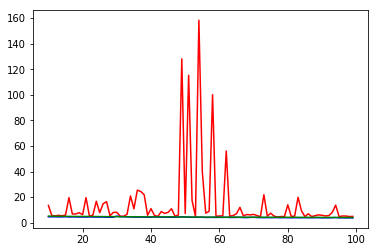

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
mob_01 = pd.read_csv(main_path + 'model_0.01.csv')
mob_001 = pd.read_csv(main_path + 'model_0.001.csv')
mob_0001 = pd.read_csv(main_path + 'model_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01['epoch'][10:], mob_01['val_loss'][10:], color='r')
ax.plot(mob_001['epoch'][10:], mob_001['val_loss'][10:], color='b')
ax.plot(mob_0001['epoch'][10:], mob_0001['val_loss'][10:], color='g')

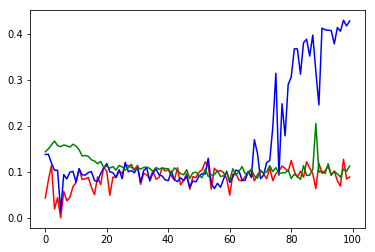

In [11]:
mob_01_f1 = pd.read_csv(main_path + 'f1_0.01.csv')
mob_001_f1 = pd.read_csv(main_path + 'f1_0.001.csv')
mob_0001_f1 = pd.read_csv(main_path + 'f1_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01_f1['epoch'], mob_01_f1['f1 score'], color='r')
ax.plot(mob_001_f1['epoch'], mob_001_f1['f1 score'], color='b')
ax.plot(mob_0001_f1['epoch'], mob_0001_f1['f1 score'], color='g')

In [10]:
scale_factors = [1.5]

for factor in scale_factors:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH FACTOR:', factor)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=factor,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=0.001)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Documents/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'data-cic/history/light_models/PASCAL/shufflenet_v2_ssdlayers_factor_' + 
                           str(factor) + '.csv',
                           separator=',',
                           append=True)

    learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)


    callbacks = [csv_logger,
                 learning_rate_scheduler]
    
    initial_epoch   = 0
    final_epoch     = 80
    steps_per_epoch = 1000

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  initial_epoch=initial_epoch)
    
    model.save(main_path + 'weights/light_models/PASCAL/shufflenet_v2_ssdlayers_factor_' + str(factor) + '.h5')

TRAINING MODEL WITH FACTOR: 1.5
Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 561s 561ms/step - loss: 5.3772
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 540s 540ms/step - loss: 4.7739
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 537s 537ms/step - loss: 4.5376
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 532s 532ms/step - loss: 4.7582
Epoch 5/80

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 533s 533ms/step - loss: 4.3632
Epoch 6/80

Epoch 00006: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 535s 535ms/step - loss: 4.2803
Epoch 7/80

Epoch 00007: LearningRateS

1000/1000 [==============================] - 559s 559ms/step - loss: 3.0512
Epoch 54/80

Epoch 00054: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 558s 558ms/step - loss: 3.0424
Epoch 55/80

Epoch 00055: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 563s 563ms/step - loss: 3.0796
Epoch 56/80

Epoch 00056: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 560s 560ms/step - loss: 3.0485
Epoch 57/80

Epoch 00057: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 561s 561ms/step - loss: 3.0388
Epoch 58/80

Epoch 00058: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 559s 559ms/step - loss: 2.9978
Epoch 59/80

Epoch 00059: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 561s 561ms/step - l